In [1]:
import numpy as np
import pandas as pd
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt
matplotlib.rcParams['figure.dpi']= 100
matplotlib.rcParams['figure.figsize'] = 15, 5

In [2]:
REGIONS = [['JH', 'Johor', 'JH'], 
           ['PH', 'Pahang', 'PH'],
           ['PRK', 'Perak', 'PRK'], 
           ['OtherPEN', 'Other Pen. States', 'OtherPEN'],
           ['PEN', 'Peninsula', 'Pmalay'],
           ['SBH', 'Sabah', 'SBH'],
           ['SWK', 'Sarawak', 'SWK']]

In [3]:
production = pd.read_csv('data/production_good.csv')
rainfall = pd.read_csv('data/rainfall_good.csv')
area = pd.read_csv('data/area_good.csv')

In [4]:
production.head()

,index,Region,Year,Month,Production,Diff_production
0,0,JH,1998,1,118.359,0.000
1,1,JH,1998,2,147.988,0.000
2,2,JH,1998,3,145.514,29.629
3,3,JH,1998,4,154.638,-2.474
4,4,JH,1998,5,155.827,9.124


In [5]:
rainfall.tail()

,Region,Year,Month,Rainfall
3439,Sarawak,2016,12,274.18
3440,Sarawak,2017,12,0.00
3441,Sarawak,2018,12,0.00
3442,Sarawak,2019,12,0.00
3443,Sarawak,2020,12,0.00


In [6]:
area.head()

,Area_New,Area_ma,Area_ma_new,Area_npa,Area_rpa,Region,Year
0,0.0,0.0,0.000000,0.0,0.0,JH,1974
1,59.0,128.0,128.000000,187.0,0.0,JH,1975
2,59.0,147.0,147.000000,206.0,0.0,JH,1976
3,56.0,171.0,116.538462,227.0,0.0,JH,1977
4,59.0,191.0,93.423077,250.0,0.0,JH,1978


In [7]:
RAINFALL_LAGS = [6, 7, 8, 9, 10, 11, 12]
PRODUCTION_LAGS = [6, 7, 8, 9, 10, 11, 12]

In [8]:
def process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS):
    output = {}
    for i, region in enumerate(REGIONS):
        data = production[production.Region == region[0]]
        data = pd.merge(data[['Year', 'Month', 'Production', 'Diff_production']],
                        rainfall[rainfall.Region == region[1]][['Year', 'Month', 'Rainfall']], 
                        on=['Year', 'Month'], how='left')

        data = pd.merge(data, area[area.Region == region[2]][
            ['Year', 'Area_ma', 'Area_npa', 'Area_rpa', 'Area_New', 'Area_ma_new']], on='Year', how='left')
            
        data['Year'] = data['Year'].astype(int)
        data['Month'] = data['Month'].astype(int)
        data.reset_index(inplace=True)

        data.set_index([pd.to_datetime(['{0}-{1}-01'.format(x, y) for (x, y) in zip(data.Year, data.Month)])],
                       inplace=True)

        data.drop(['index', 'Year', 'Area_New', 'Diff_production'], axis=1, inplace=True)
        data['Time'] = np.arange(len(data))

        for lag in RAINFALL_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Rainfall.values[:-lag]))
            data['Rainfall_{0}'.format(lag)] = temp

        for lag in PRODUCTION_LAGS:
            temp = np.concatenate((np.array([np.nan for _ in range(lag)]), data.Production.values[:-lag]))
            data['Production_{0}'.format(lag)] = temp
        
        PRODUCTION = data.Production
        data.drop(['Production'], axis=1, inplace=True)

        data.fillna(data.mean(), inplace=True)

        #  And finally drop rainfalls
        data.drop(['Rainfall'], axis=1, inplace=True)
        ### HERE I CAN ADD FEATURE ENGINEERING!!!

        #  And clip first year
        for col in data.columns:
            data['_'.join([region[1], str(col)])] = data[col]
            data.drop([col], axis=1, inplace=True)
        
        output[region[1]] = (data[max(PRODUCTION_LAGS):], PRODUCTION[max(PRODUCTION_LAGS):])
    return output


In [9]:
DATA = process_data(production, rainfall, area, REGIONS, PRODUCTION_LAGS, RAINFALL_LAGS)

In [10]:
DATA['Johor'][0].index

DatetimeIndex(['1999-01-01', '1999-02-01', '1999-03-01', '1999-04-01',
               '1999-05-01', '1999-06-01', '1999-07-01', '1999-08-01',
               '1999-09-01', '1999-10-01',
               ...
               '2016-12-01', '2017-01-01', '2017-02-01', '2017-03-01',
               '2017-04-01', '2017-05-01', '2017-06-01', '2017-07-01',
               '2017-08-01', '2017-09-01'],
              dtype='datetime64[ns]', length=225, freq=None)

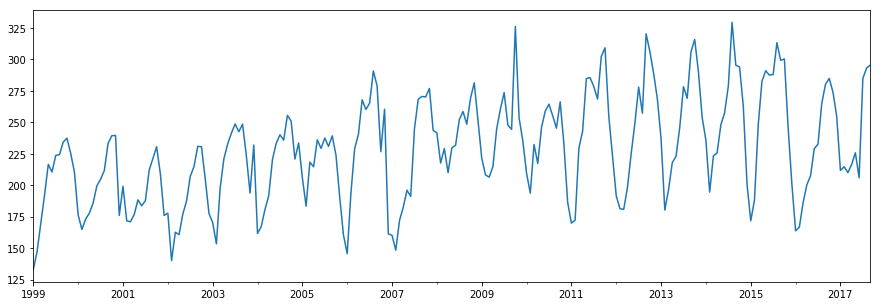

In [11]:
DATA['Johor'][1].plot(figsize=(15,5))

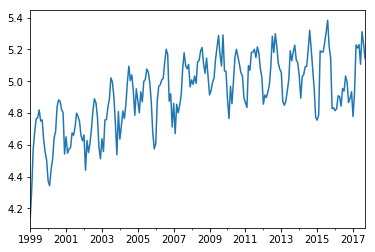

In [12]:
np.log(DATA['Perak'][1]).plot()

In [13]:
DATA['Perak'][1]['2016-01-01']

123.32700000000001

# MA

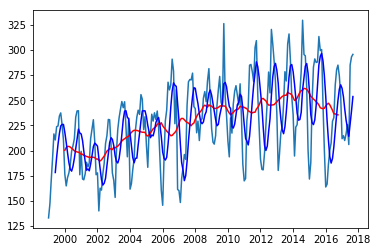

In [14]:
ts = DATA['Johor'][1]
ts_log = np.log(DATA['Johor'][1])

ts_moving_avg_center = ts.rolling(24, center=True).mean()
ts_moving_avg_right = ts.rolling(6, center=False).mean()
plt.plot(ts)
plt.plot(ts_moving_avg_center, color='red')
plt.plot(ts_moving_avg_right, color='blue')

# Shocks

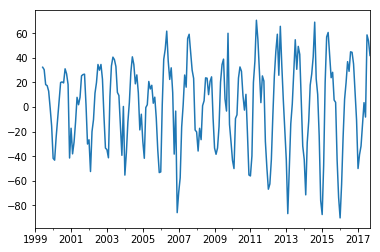

In [15]:
ts_ma_diff = ts - ts_moving_avg_right
ts_ma_diff.plot()

In [16]:
np.nanmean(ts_ma_diff)

1.0263863636364488

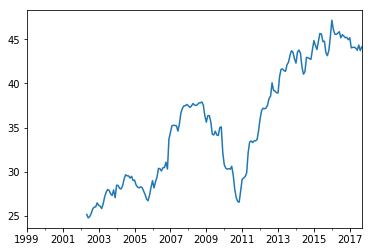

In [17]:
ts_ma_diff.rolling(36).std().plot()

# Stationarity

In [18]:
from statsmodels.tsa.stattools import adfuller
def stationarity_test(ts):
    
    rolmean = ts.rolling(12).mean()
    rolstd = ts.rolling(12).std()

    orig = plt.plot(ts, color='blue',label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    std = plt.plot(rolstd, color='black', label = 'Rolling Std')

    # Dickey-Fuller test:
    print("Results of Dickey-Fuller Test:")
    dftest = adfuller(ts, autolag='AIC')
    print(dftest)     
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','#Lags Used','Number of Observations Used'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)    

Results of Dickey-Fuller Test:
(-1.6296735283340256, 0.4676616062382262, 15, 209, {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}, 1864.119597376337)
Test Statistic                  -1.629674
p-value                          0.467662
#Lags Used                      15.000000
Number of Observations Used    209.000000
Critical Value (1%)             -3.462032
Critical Value (5%)             -2.875471
Critical Value (10%)            -2.574195
dtype: float64


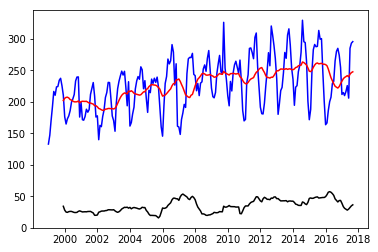

In [19]:
stationarity_test(ts)

Results of Dickey-Fuller Test:
(-1.7842331980725419, 0.3883170898532328, 15, 197, {'1%': -3.463987334463603, '5%': -2.8763259091636213, '10%': -2.5746515171738515}, 1761.0366656739584)
Test Statistic                  -1.784233
p-value                          0.388317
#Lags Used                      15.000000
Number of Observations Used    197.000000
Critical Value (1%)             -3.463987
Critical Value (5%)             -2.876326
Critical Value (10%)            -2.574652
dtype: float64


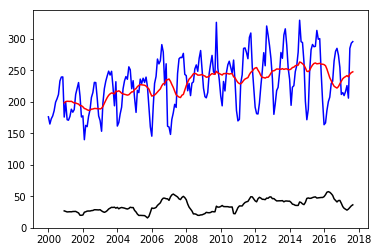

In [20]:
stationarity_test(ts[12:])

# Exponentially weighted moving average

In [22]:
expwighted_avg = ts.ewm(span=12)

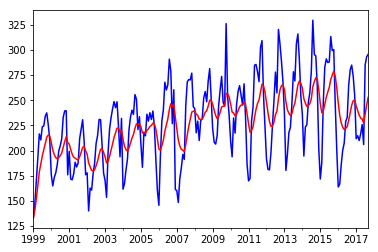

In [46]:
ts.plot(color="blue", label="Original")
expwighted_avg.plot(color="red", label="EWMA")

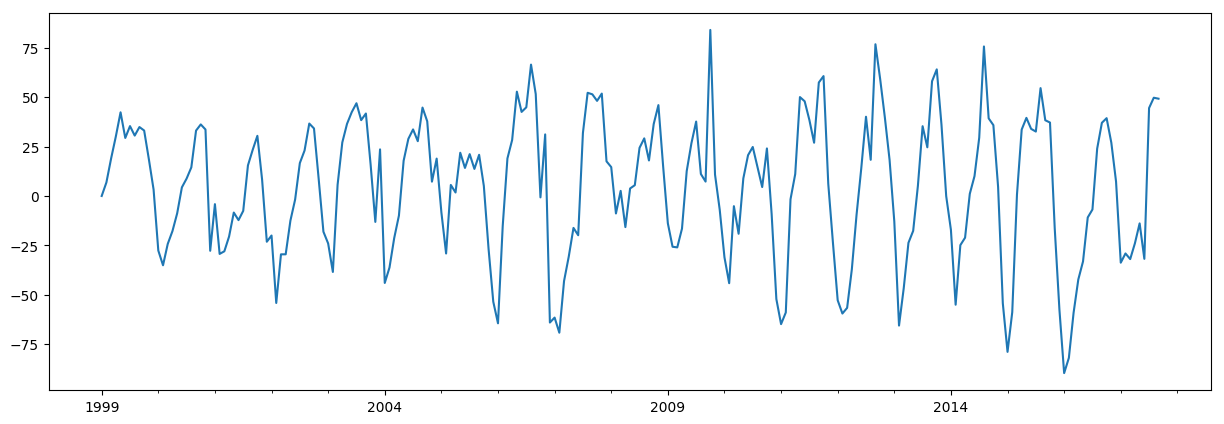

In [47]:
ts_exp_diff = ts - expwighted_avg
ts_exp_diff.plot()

Results of Dickey-Fuller Test:
(-4.867493990994961, 4.032771904712169e-05, 12, 212, {'1%': -3.4615775784078466, '5%': -2.875271898983725, '10%': -2.5740891037735847}, 1832.5893191009666)
Test Statistic                  -4.867494
p-value                          0.000040
#Lags Used                      12.000000
Number of Observations Used    212.000000
Critical Value (1%)             -3.461578
Critical Value (5%)             -2.875272
Critical Value (10%)            -2.574089
dtype: float64


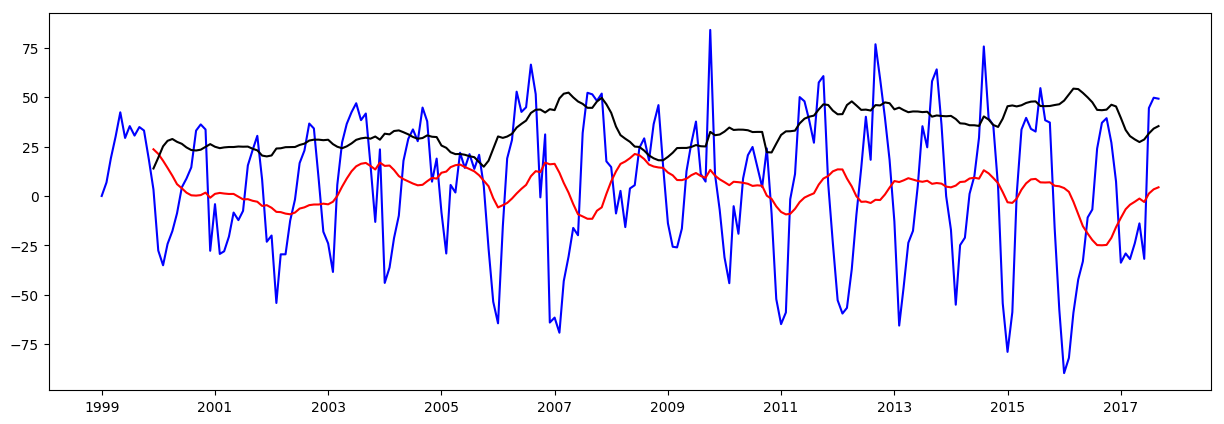

In [48]:
stationarity_test(ts_exp_diff)

# Decomposition and differencing

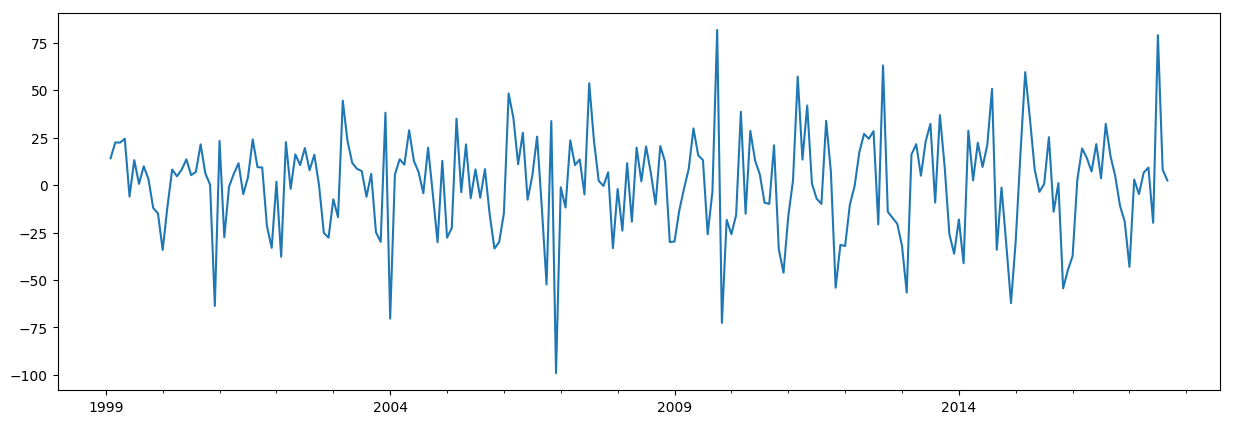

In [50]:
# Diff
ts_diff = ts - ts.shift(1)
ts_diff.plot()

Results of Dickey-Fuller Test:
(-6.460838342009528, 1.4446217234580329e-08, 14, 209, {'1%': -3.4620315036789666, '5%': -2.8754705024827127, '10%': -2.5741950726860647}, 1857.1871112827093)
Test Statistic                -6.460838e+00
p-value                        1.444622e-08
#Lags Used                     1.400000e+01
Number of Observations Used    2.090000e+02
Critical Value (1%)           -3.462032e+00
Critical Value (5%)           -2.875471e+00
Critical Value (10%)          -2.574195e+00
dtype: float64


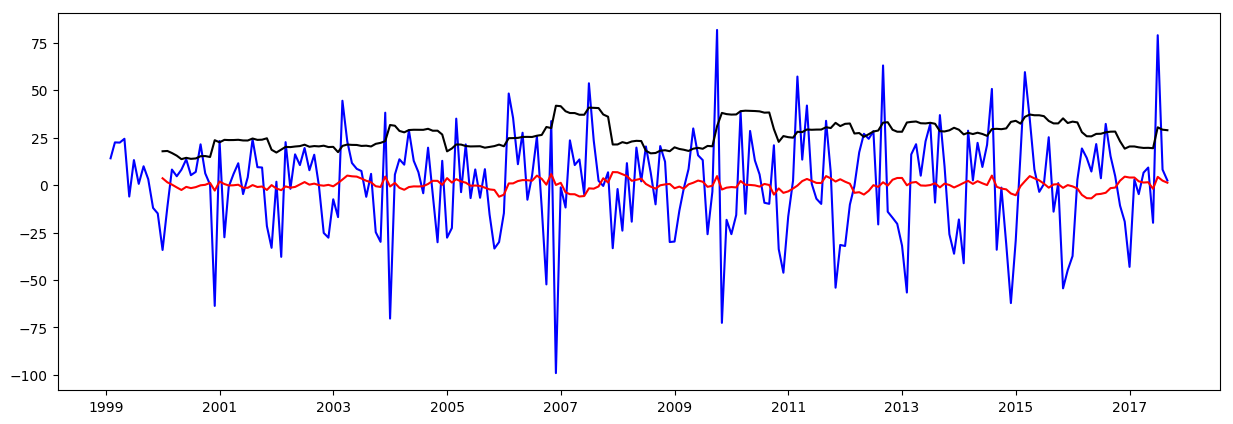

In [51]:
ts_diff.dropna(inplace=True)
stationarity_test(ts_diff)

In [143]:
# My decompose
from statsmodels.tsa.seasonal import seasonal_decompose

def _decompose(ts, freq):
    decomposition = seasonal_decompose(ts, freq=freq)

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    plt.subplot(411)
    plt.plot(ts, label='Original')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals')
    plt.legend(loc='best')
    plt.tight_layout()
    return residual

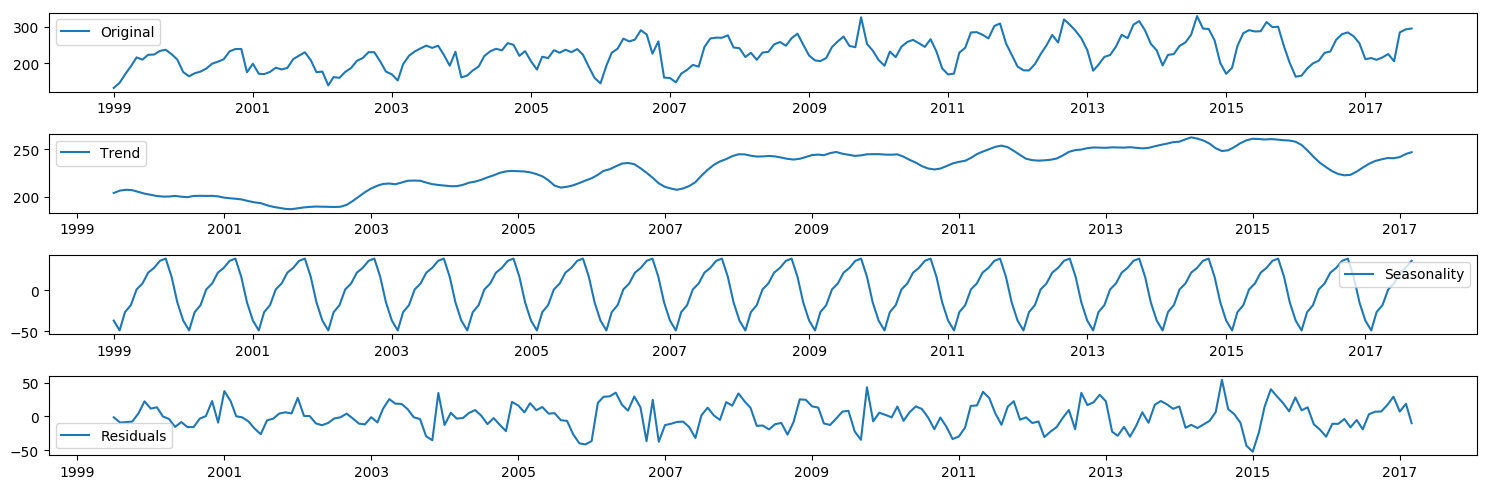

In [144]:
res = _decompose(ts, 12)

Results of Dickey-Fuller Test:
(-8.109460063834723, 1.2370788762177932e-12, 14, 198, {'1%': -3.4638151713286316, '5%': -2.876250632135043, '10%': -2.574611347821651}, 1635.9554679749076)
Test Statistic                -8.109460e+00
p-value                        1.237079e-12
#Lags Used                     1.400000e+01
Number of Observations Used    1.980000e+02
Critical Value (1%)           -3.463815e+00
Critical Value (5%)           -2.876251e+00
Critical Value (10%)          -2.574611e+00
dtype: float64


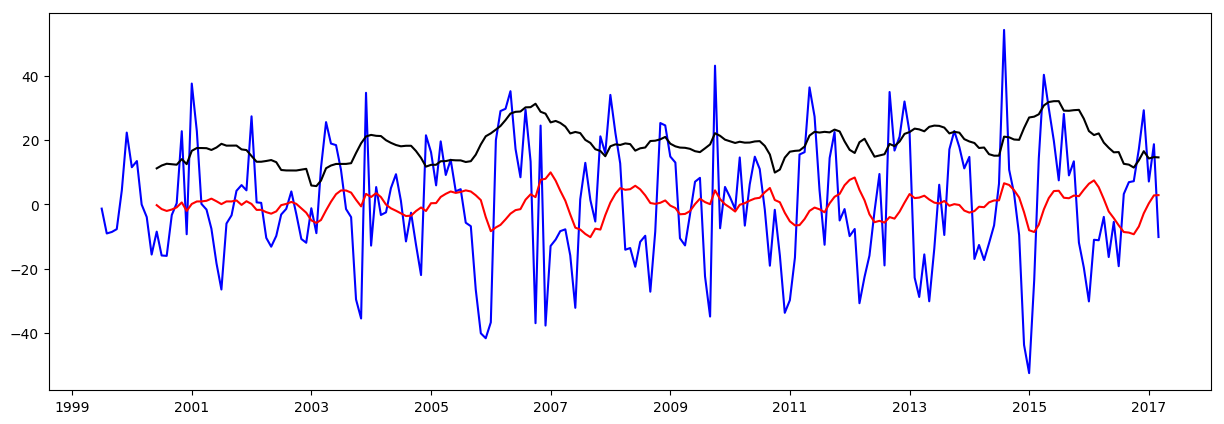

In [146]:
res.dropna(inplace=True)
stationarity_test(res)

# ARIMA

1. Number of AR (Auto-Regressive) terms $(p)$: AR terms are just lags of dependent variable. For instance if $p=5,$ the predictors for $x_t$ will be $x_{t-1}\ldots x_{t-1}.$
2. Number of MA (Moving Average) terms $(q):$ MA terms are lagged forecast errors in prediction equation. For instance if $q=5,$ the predictors for $x_{t}$ will be $\varepsilon_{t-1}\ldots\varepsilon_{t-5}$ where $\varepsilon_{i}$ is the difference between the moving average at ith instant and actual value.
3. Number of Differences $(d):$ These are the number of nonseasonal differences, i.e. in this case we took the first order difference. So either we can pass that variable and put $d=0$ or pass the original variable and put $d=1.$ Both will generate same results.

In [158]:
from statsmodels.tsa.arima_model import ARIMA
#ACF and PACF plots:
from statsmodels.tsa.stattools import acf, pacf
lag_acf = acf(res, nlags=5)
lag_pacf = pacf(res, nlags=5, method='ols')

[ 1.          0.44281662  0.2189719  -0.02221288 -0.26607038 -0.3554238 ]


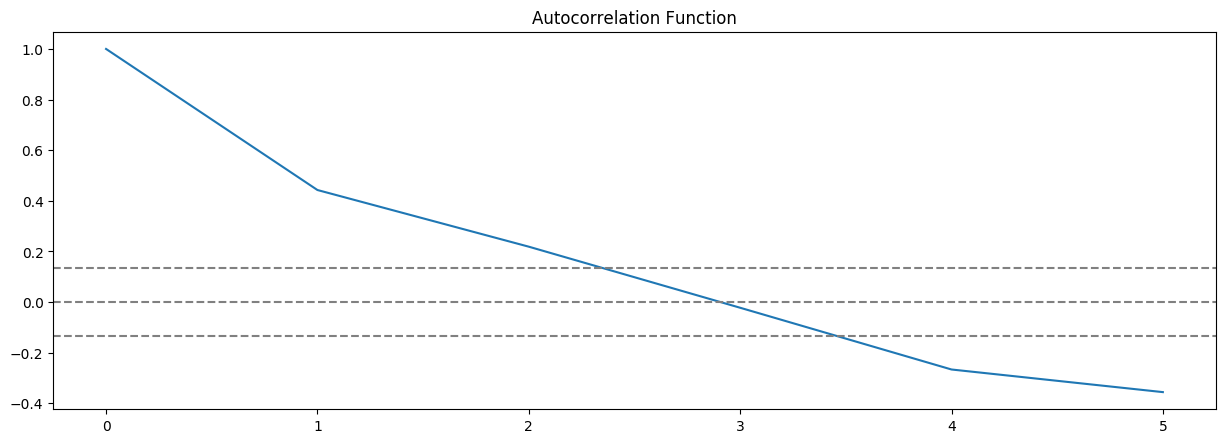

In [155]:
#Plot ACF: 
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.title('Autocorrelation Function')
print(lag_acf)

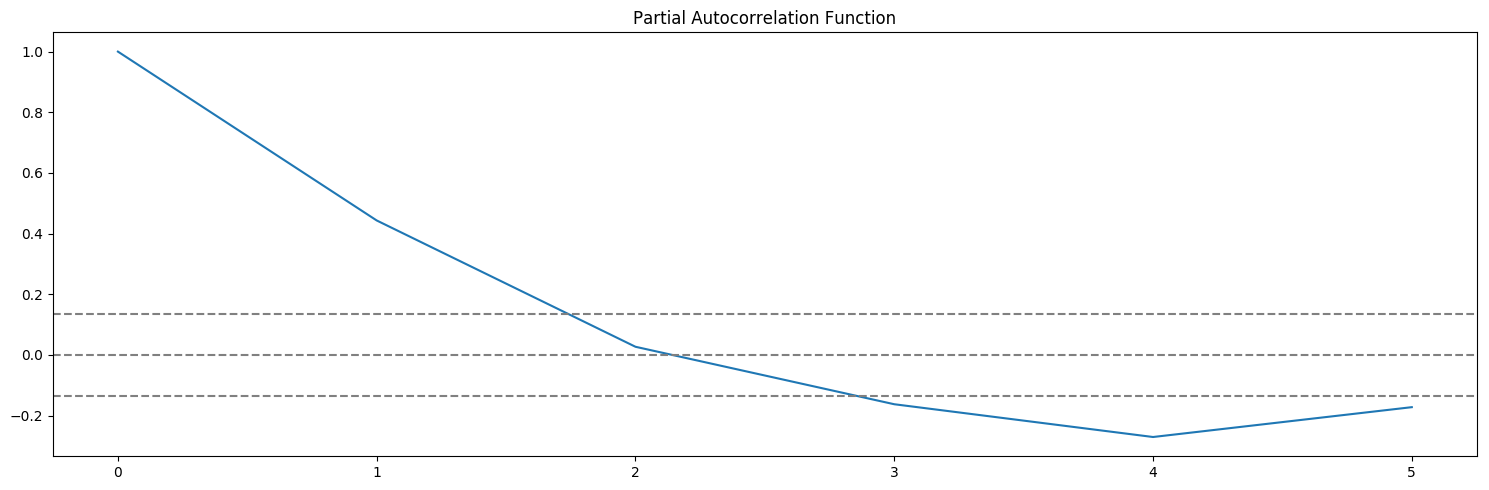

In [156]:
#Plot PACF:
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='gray')
plt.axhline(y=-1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.axhline(y=1.96/np.sqrt(len(res)),linestyle='--',color='gray')
plt.title('Partial Autocorrelation Function')
plt.tight_layout()

# AR model

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RMSE: 245.1467')

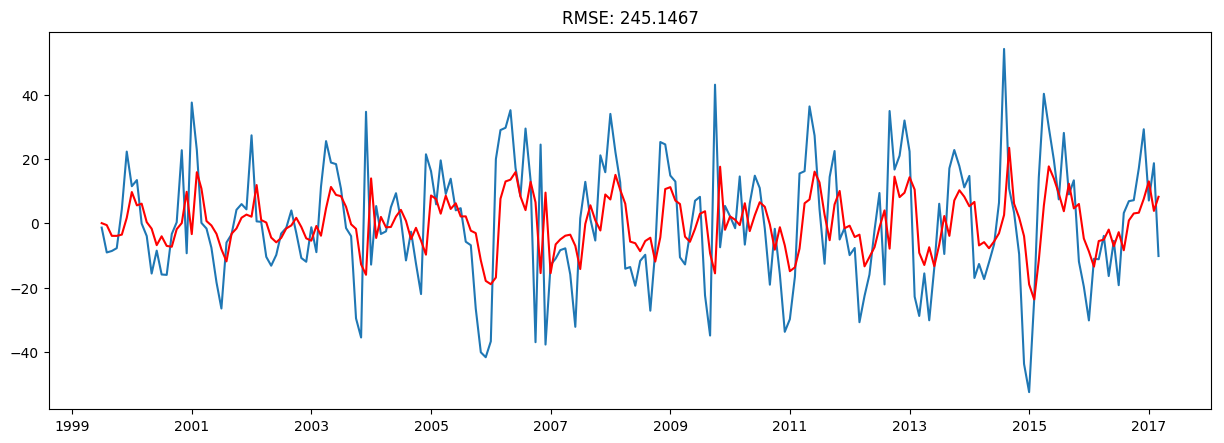

In [161]:
model = ARIMA(res, order=(2, 0, 0))  
results_AR = model.fit(disp=-1)  
plt.plot(res)
plt.plot(results_AR.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((results_AR.fittedvalues-res)**2)))

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RMSE: 241.0333')

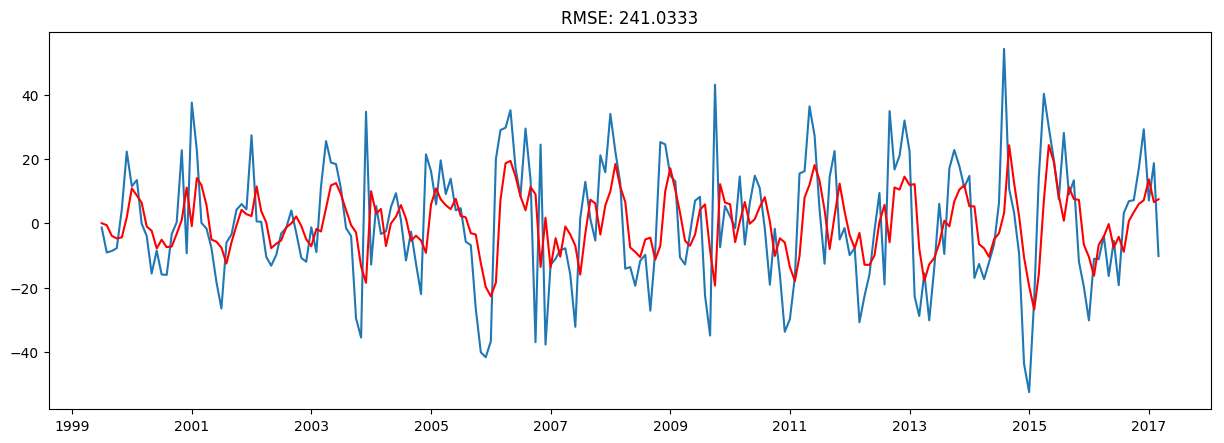

In [162]:
model = ARIMA(res, order=(0, 0, 3))  
results_MA = model.fit(disp=-1)  
plt.plot(res)
plt.plot(results_MA.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((results_MA.fittedvalues-res)**2)))

/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):
/usr/local/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


Text(0.5,1,'RMSE: 218.6584')

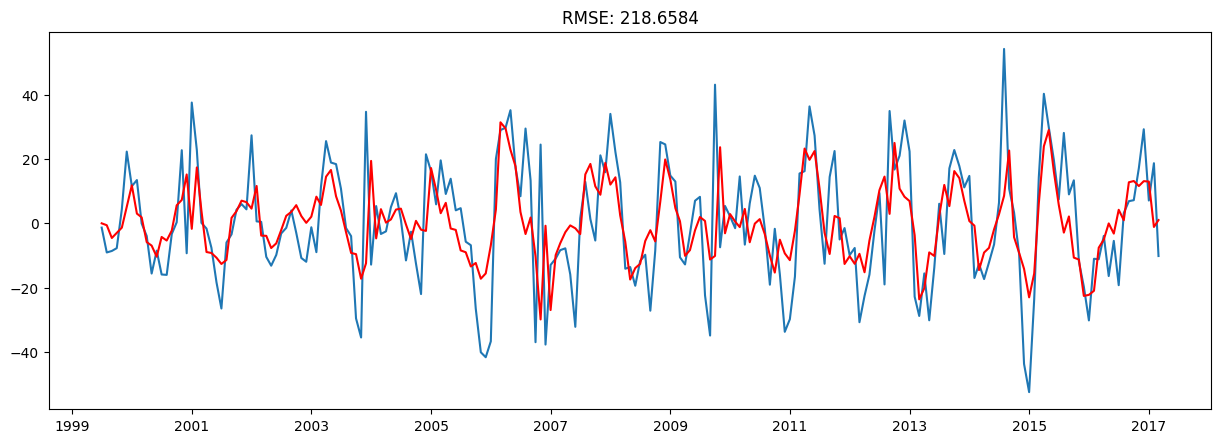

In [167]:
model = ARIMA(res, order=(2, 0, 1))  
results_ARMA = model.fit(disp=-1)  
plt.plot(res)
plt.plot(results_ARMA.fittedvalues, color='red')
plt.title('RMSE: %.4f'% np.sqrt(sum((results_ARMA.fittedvalues-res)**2)))

### FFT in forecasting

In [100]:
def fourierExtrapolation(x, n_predict, harm):
    n = x.size
    restored_ind = x.index
    restored_ind = restored_ind.append(x.shift(n_predict, freq="MS").index[-n_predict:])
    n_harm = harm  # number of harmonics in model
    x_freqdom = np.fft.fft(x)  # detrended x in frequency domain
    f = np.fft.fftfreq(n)  # frequencies
    indexes = list(range(n))
    # sort indexes by frequency, lower -> higher
    indexes.sort(key=lambda i: np.absolute(f[i]))

    t = np.arange(0, n + n_predict)
    restored_sig = np.zeros(t.size)
    for i in indexes[:1 + n_harm * 2]:
        ampli = np.absolute(x_freqdom[i]) / n  # amplitude
        phase = np.angle(x_freqdom[i])  # phase
        restored_sig += ampli * np.cos(2 * np.pi * f[i] * t + phase)
    return pd.Series(data=restored_sig, index=restored_ind)

In [158]:
restored_fourier = fourierExtrapolation(ts, 60, 100)

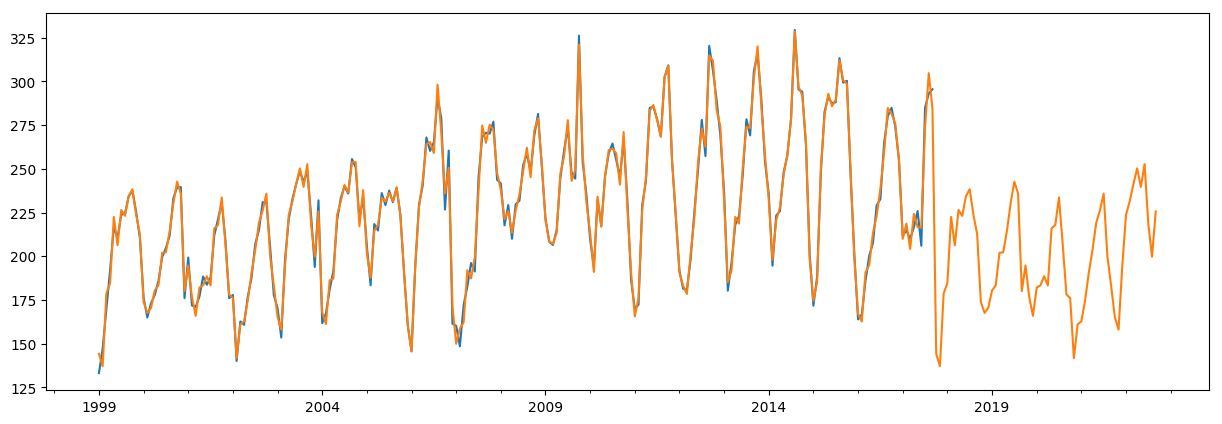

In [159]:
ts.plot()
restored_fourier.plot()

In [112]:
import cesium